# Sparse Invariance

## Intro
* **Date**: 1/4/2021
* **What**: Basically the same thing as the last experiment, but now I'm adding sparsity to the invariant layer.  So to get a bit more technical, the second layer is also going to be multiple winner-takes-all as well, but trained in the invariant "smoothing" fashion.
* **Why**: I want smooth behavior throughout time, but gosh darn it, I want sparsity.  Basically, the idea is that only a couple invariant neurons would be "on" at the same time, so why not enforce it to ensure it happens.
* **Hopes**: I was starting to get smoother behavior at the end of the last experiment, but it was basically mush.  I want to see smooth behavior in the invariant layer, but I also only want to see a couple neurons "on" at a time (which is enforced with mwta sparsity).
* **Limitations**: Again, I don't really know.  But, I'll be golly gee gosh darned, that's kinda exciting!  It's kinda interesting to think I don't even have a conception about how this will break, and what I'll learn from this experiment.  That's actually kinda dope!!  Here we go fam!

## Code

In [ ]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 3000

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [13]:
def draw_weights_no_colorbar(w, Kx, Ky, s_len):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)

In [2]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 100_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


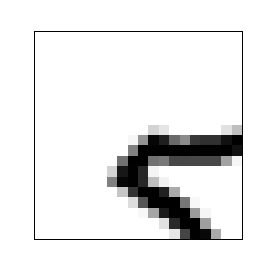

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [4]:
tap_val = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 10000

for x in range(t_sl):
    for y in range(t_sl):

        tap_val[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tap_val[(t_sl - 1) * m_sl:, :] = tap_val[: m_sl, :]
tap_val[:, (t_sl - 1) * m_sl:] = tap_val[:, : m_sl]

In [5]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_val = img_array.reshape(-1, sl ** 2)
gp_val = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


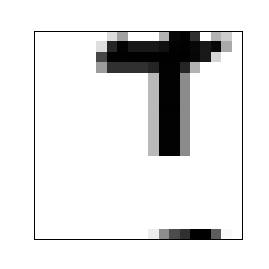

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

## Analysis Dialog

Here we go!

<IPython.core.display.Javascript object>


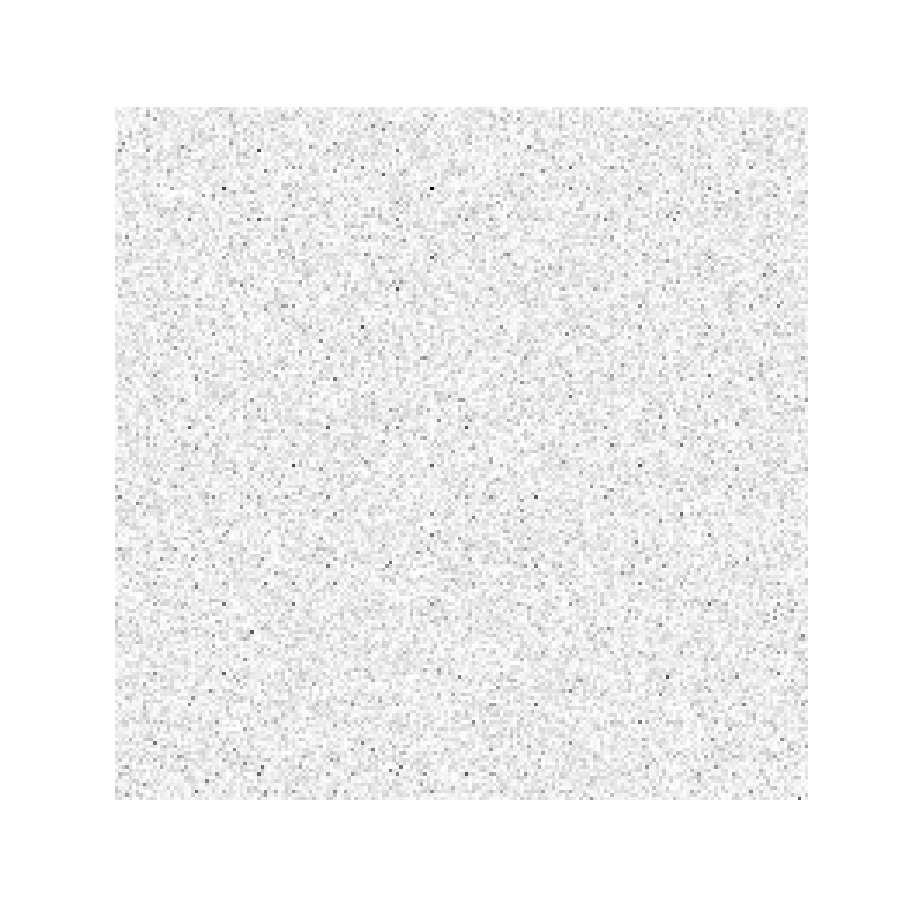

100%|██████████| 10000/10000 [00:12<00:00, 811.49it/s]


In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 10
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

in_w = 10 #Number of winners in the invariant layer

iw = cp.random.uniform(0, 1, (iN, sN))
zeta = 0.05


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    so_b = cp.zeros((sN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        p = iw @ so
        winners = cp.argsort(p, axis=0)[-in_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        io = mask * p
        
        io_p = (io + io_bb) / 2
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so_b > 0, so_b - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io
        
        so_b = so
    
    draw_weights(iw.get(), Ix, Iy, Kx, fig)

<IPython.core.display.Javascript object>


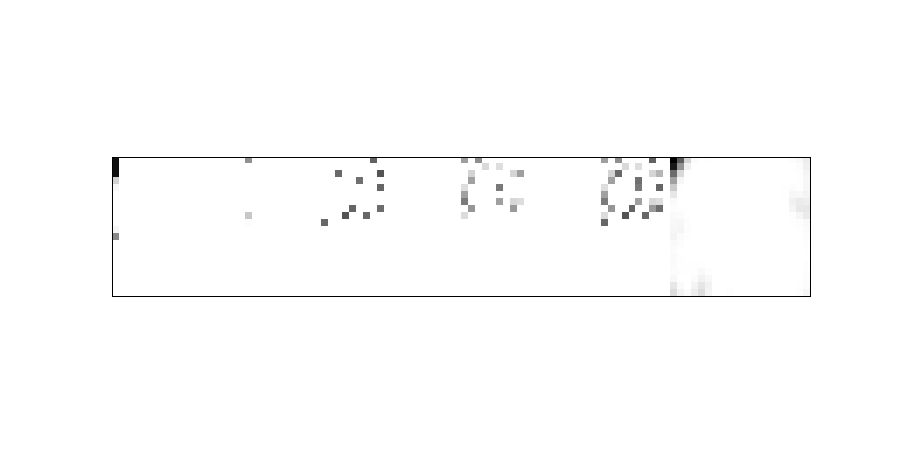

100%|██████████| 500/500 [00:00<00:00, 508.44it/s]


In [20]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    p = iw_np @ so
    winners = np.argsort(p, axis=0)[-in_w:]
    mask = np.zeros((iN, 1))
    mask[winners] = 1
    io = mask * p

    io_p = (io + io_bb) / 2

    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io_bb.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io_bb - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

<IPython.core.display.Javascript object>


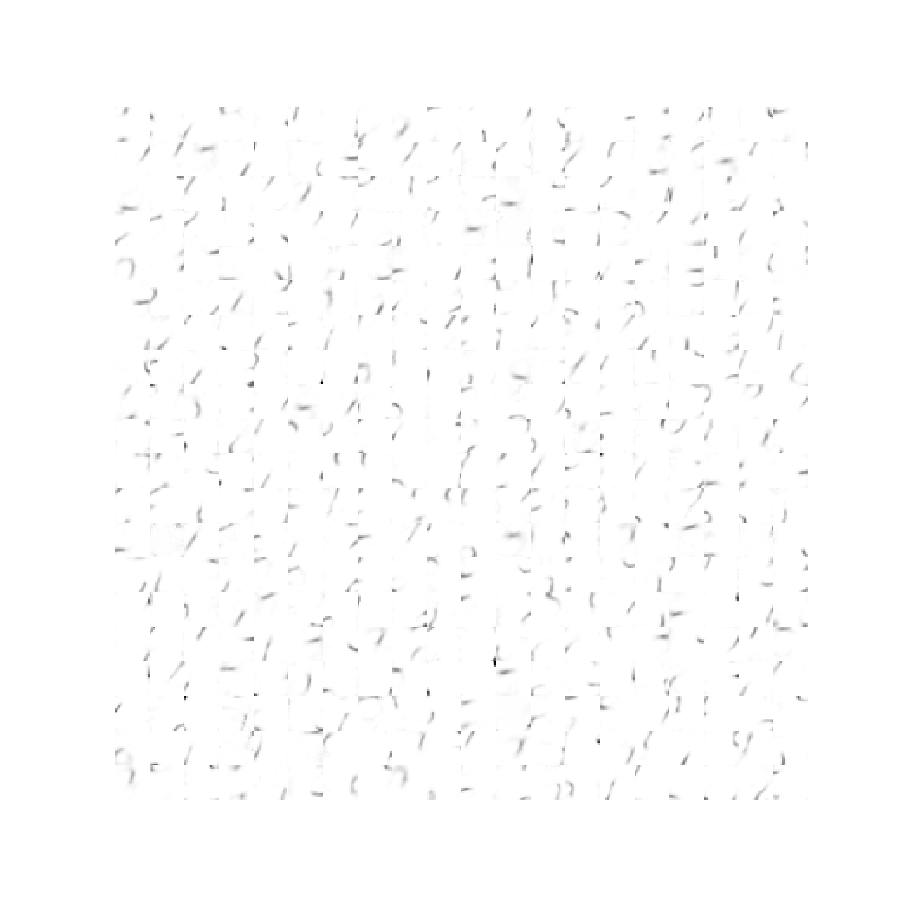

In [21]:
fig = plt.figure(figsize=(10, 10))
draw_weights(sw.get(), Kx, Ky, sl, fig)

Well, that animation was in a word, disheartening.  I'm going to train this again with more epochs, and I'm going to mess with the plotter so I can see what's going on in both layers.  I don't want the first layer going crazy on me.

<IPython.core.display.Javascript object>


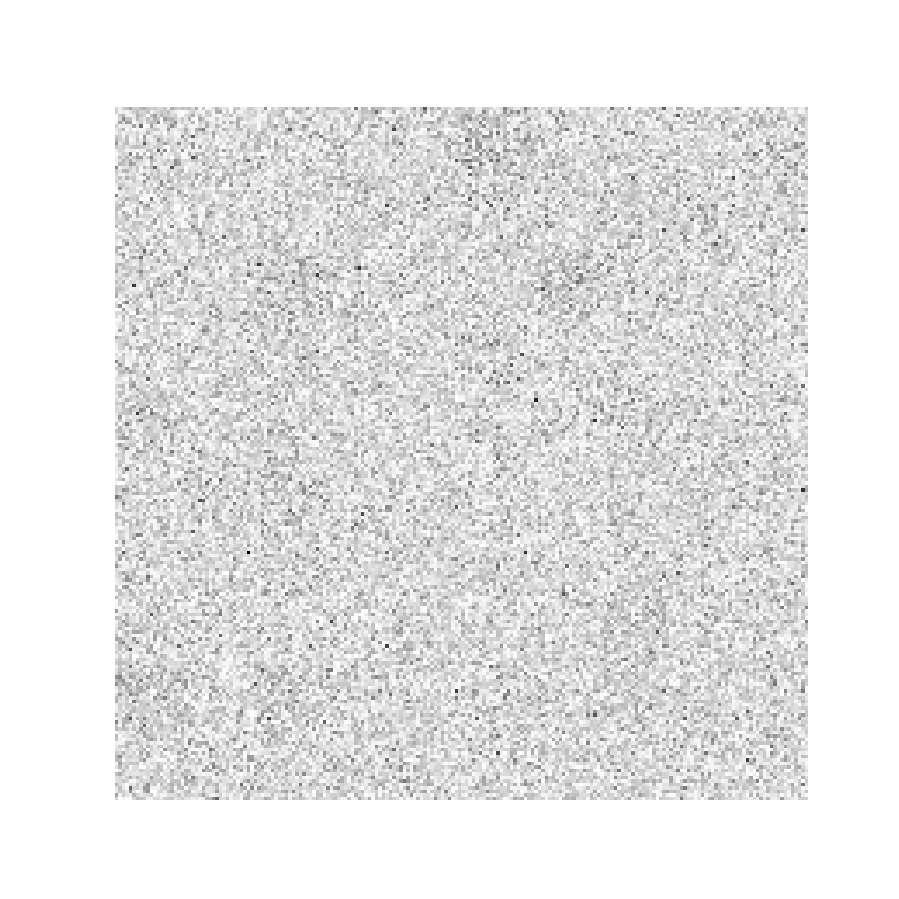

100%|██████████| 10000/10000 [00:11<00:00, 856.91it/s]


In [24]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

in_w = 10 #Number of winners in the invariant layer

iw = cp.random.uniform(0, 1, (iN, sN))
zeta = 0.1


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    so_b = cp.zeros((sN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        p = iw @ so
        winners = cp.argsort(p, axis=0)[-in_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        io = mask * p
        
        io_p = (io + io_bb) / 2
        r = iw.T @ io_p
        mod_r = cp.maximum(r, prec)
        e = cp.where(so_b > 0, so_b - r, 0)

        iw += iw * io_p * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io
        
        so_b = so
    if (ep // 2) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

<IPython.core.display.Javascript object>


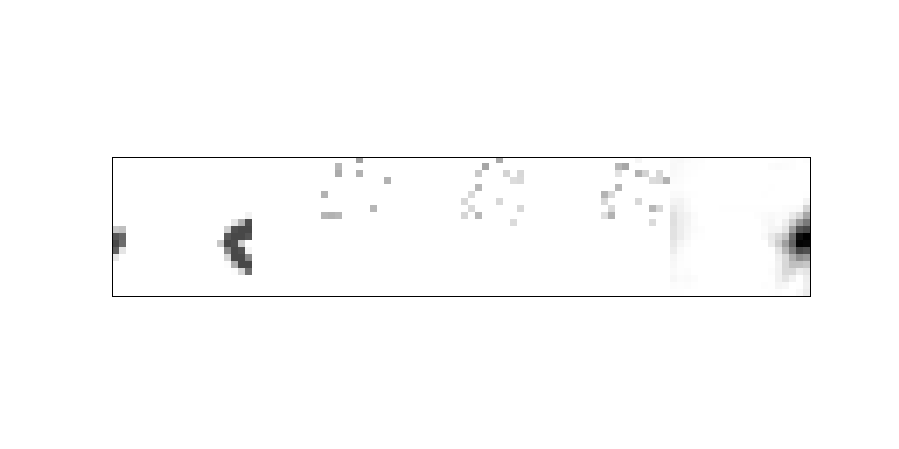

100%|██████████| 500/500 [00:00<00:00, 512.48it/s]


In [25]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    p = iw_np @ so
    winners = np.argsort(p, axis=0)[-in_w:]
    mask = np.zeros((iN, 1))
    mask[winners] = 1
    io = mask * p

    io_p = (io + io_bb) / 2

    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io_bb.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io_bb - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ok, well it's pretty clear sparsity alone doesn't solve the problem.  Just look at the above image.  I think my basic premise of changing the weights based on the final output reconstruction is kinda weird.  The purpose of reconstruction is in part to normalize.  So I think I need to adjust the weights to that the actual output matches the linear interpolation, *and* does a good job at reconstruction.  

Hmm, I think I'm going to finish this experiment, come up with the new algorithm, and go from there.

## Conclusions

I basically just wrote this experiment's conclusion.  For some reasons I assumed that using the linearly interpolated prediction as the basis for reconstruction would magically make the network move weights more toward the linearly interpolated value.  Instead, I think it's basically just chaos.  Well, I mean if the above animation is at all in line with reality, then yes, it's chaos.  So, next steps...

## Next steps

I think I'm going to have to come up with an update rule for the invariant layer that both tries to make the output equal the linear interpolation and tries to make the reconstruction as good as possible.  Reconstruction should normalize, and the other update rule should hopefully add smoothness.